### データの読み込み

In [1]:
import random
import numpy as np
import pandas as pd
import torch
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm

In [44]:
#学習データ
class my_dataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.num_classes = 1854

        # 4108x271x281
        self.X = torch.load("./data/train_image.pt").numpy()
        
        self.y = torch.tensor(np.loadtxt("./data/train_image_y.txt"), dtype=torch.int64)
        assert len(torch.unique(self.y)) == self.num_classes, "Number of classes do not match."
        
        if self.transform is not None:
            self.ch_shape=self.transform(self.X[0]).shape[0]
            self.seq_shape=self.transform(self.X[0]).shape[1]
        else:
            self.ch_shape=self.X[0].shape[0]
            self.seq_shape=self.X[0].shape[1]

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        if self.transform is not None:
            out_X=self.transform(self.X[i])
        else:
            out_X=self.X[i]

        return out_X, self.y[i]

image_dataset = my_dataset()

(48, 48, 3) <class 'numpy.ndarray'> tensor(1759., dtype=torch.float64) 22448


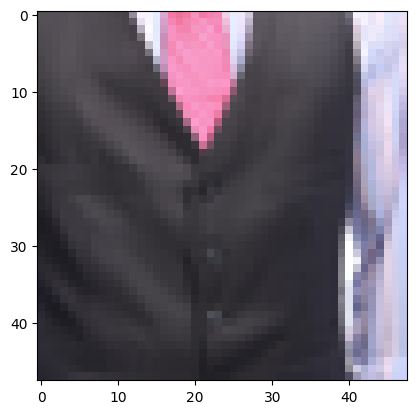

In [3]:
import matplotlib.pyplot as plt
X,y=image_dataset[0]
print(X.shape, type(X), y, len(image_dataset))
plt.imshow(X)

### データローダの準備  

In [4]:
train_transform = transforms.Compose(
    [transforms.RandomCrop(48),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

valid_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

valid_size=3000
train_dataset, valid_dataset = torch.utils.data.random_split(
    image_dataset, 
    [int(len(image_dataset)-valid_size), int(valid_size)]
)

#train_dataset.transform=train_transform
image_dataset.transform=valid_transform

batch_size = 256

dataloader_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=4,
    pin_memory=True,
    #persistent_workers=True
)

dataloader_valid = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=4,
    pin_memory=True,
    #persistent_workers=True
)

### 自己教師あり学習の実装
- 初期の形式はMAEを利用することを想定していますが，他の自己教師あり学習を利用していただいて構いません．   

In [5]:
import math
import torch.nn as nn
import torch.optim as optim
from einops.layers.torch import Rearrange
from einops import rearrange

def fix_seed(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


fix_seed(seed=42)

Attention

In [6]:
class Attention(nn.Module):
    def __init__(self, dim, heads, dim_head, dropout=0.):
        """
        Arguments
        ---------
        dim : int
            入力データの次元数．埋め込み次元数と一致する．
        heads : int
            ヘッドの数．
        dim_head : int
            各ヘッドのデータの次元数．
        dropout : float
            Dropoutの確率(default=0.)．
        """
        super().__init__()

        self.dim = dim
        self.dim_head = dim_head
        inner_dim = dim_head * heads  # ヘッドに分割する前のQ, K, Vの次元数．self.dimと異なっても良い．
        project_out = not (heads == 1 and dim_head == dim)  # headsが1，dim_headがdimと等しければ通常のSelf-Attention

        self.heads = heads
        self.scale = math.sqrt(dim_head)  # ソフトマックス関数を適用する前のスケーリング係数(dim_k)

        self.attend = nn.Softmax(dim=-1)  # アテンションスコアの算出に利用するソフトマックス関数
        self.dropout = nn.Dropout(dropout)

        # Q, K, Vに変換するための全結合層
        self.to_q = nn.Linear(in_features=dim, out_features=inner_dim)
        self.to_k = nn.Linear(in_features=dim, out_features=inner_dim)
        self.to_v = nn.Linear(in_features=dim, out_features=inner_dim)

        # dim != inner_dimなら線形層を入れる，そうでなければそのまま出力
        self.to_out = nn.Sequential(
            nn.Linear(in_features=inner_dim, out_features=dim),
            nn.Dropout(dropout),
        ) if project_out else nn.Identity()

    def forward(self, x):
        """
        B: バッチサイズ
        N: 系列長
        D: データの次元数(dim)
        """
        B, N, D = x.size()

        # 入力データをQ, K, Vに変換する
        # (B, N, dim) -> (B, N, inner_dim)
        q = self.to_q(x)
        k = self.to_k(x)
        v = self.to_v(x)

        # Q, K, Vをヘッドに分割する
        # (B, N, inner_dim) -> (B, heads, N, dim_head)
        q = rearrange(q, "b n (h d) -> b h n d", h=self.heads, d=self.dim_head)
        k = rearrange(k, "b n (h d) -> b h n d", h=self.heads, d=self.dim_head)
        v = rearrange(v, "b n (h d) -> b h n d", h=self.heads, d=self.dim_head)

        # QK^T / sqrt(d_k)を計算する
        # (B, heads, N, dim_head) x (B, heads, dim_head, N) -> (B, heads, N, N)
        dots = torch.matmul(q, k.transpose(-2, -1)) / self.scale

        # ソフトマックス関数でスコアを算出し，Dropoutをする
        attn = self.attend(dots)
        attn = self.dropout(attn)

        # softmax(QK^T / sqrt(d_k))Vを計算する
        # (B, heads, N, N) x (B, heads, N, dim_head) -> (B, heads, N, dim_head)
        out = torch.matmul(attn ,v)

        # もとの形に戻す
        # (B, heads, N, dim_head) -> (B, N, dim)
        out = rearrange(out, "b h n d -> b n (h d)", h=self.heads, d=self.dim_head)

        # 次元が違っていればもとに戻して出力
        # 表現の可視化のためにattention mapも返すようにしておく
        return self.to_out(out), attn

In [7]:
attn = Attention(384, 12, 32, 0.) # dim, heads, dim_head, dropout
x = torch.rand(4, 64, 384)  # (Batch, N, Dim)
attn(x)[0].shape

torch.Size([4, 64, 384])

Feed-forward network
=multi layer perceptron

In [8]:
class FFN(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        """
        Arguments
        ---------
        dim : int
            入力データの次元数．
        hidden_dim : int
            隠れ層の次元．
        dropout : float
            各全結合層の後のDropoutの確率(default=0.)．
        """
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(in_features=dim, out_features=hidden_dim),
            nn.GELU(), # Gaussian Error Linear Unit: ReLUに似た形状だがx=0で微分可能
            nn.Dropout(dropout),
            nn.Linear(in_features=hidden_dim, out_features=dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        """
        (B, D) -> (B, D)
        B: バッチサイズ
        D: 次元数
        """
        return self.net(x)

In [9]:
ffn = FFN(384, 768, 0.) # (dim, hidden_dim, dropout)
x = torch.rand(4, 64, 384)  # (Batch, N, Dim)
ffn(x).shape

torch.Size([4, 64, 384])

Transformer block

In [10]:
class Block(nn.Module):
    def __init__(self, dim, heads, dim_head, mlp_dim, dropout):
        """
        TransformerのEncoder Blockの実装．

        Arguments
        ---------
        dim : int
            埋め込みされた次元数．PatchEmbedのembed_dimと同じ値．
        heads : int
            Multi-Head Attentionのヘッドの数．
        dim_head : int
            Multi-Head Attentionの各ヘッドの次元数．
        mlp_dim : int
            Feed-Forward Networkの隠れ層の次元数．
        dropout : float
            Droptou層の確率p．
        """
        super().__init__()

        self.attn_ln = nn.LayerNorm(dim)  # Attention前のLayerNorm
        self.attn = Attention(dim, heads, dim_head, dropout)
        self.ffn_ln = nn.LayerNorm(dim)  # FFN前のLayerNorm
        self.ffn = FFN(dim, mlp_dim, dropout)

    def forward(self, x, return_attn=False):
        """
        x: (B, N, dim)
        B: バッチサイズ
        N: 系列長
        dim: 埋め込み次元
        """
        y, attn = self.attn(self.attn_ln(x))
        if return_attn:  # attention mapを返す（attention mapの可視化に利用）
            return attn
        x = y + x
        out = self.ffn(self.ffn_ln(x)) + x

        return out

In [11]:
block = Block(384, 12, 32, 384, 0.) # (dim, heads, dim_head, mlp.dim, dropout)
x = torch.rand(4, 64, 384)  # (Batch, N, Dim)
block(x).shape

torch.Size([4, 64, 384])

Patch embedding

In [12]:
class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, embed_dim):
        """
        入力画像をパッチごとに埋め込むための層．

        Arguments
        ---------
        image_size : Tuple[int]
            入力画像のサイズ．
        patch_size : Tuple[int]
            各パッチのサイズ．
        in_channels : int
            入力画像のチャネル数．
        embed_dim : int
            埋め込み後の次元数．
        """
        super().__init__()

        image_height, image_width = image_size
        patch_height, patch_width = patch_size

        assert image_height % patch_height == 0 and image_width % patch_width == 0, "パッチサイズは，入力画像のサイズを割り切れる必要があります．"

        num_patches = (image_height // patch_height) * (image_width // patch_width)  # パッチの数
        patch_dim = in_channels * patch_height * patch_width  # 各パッチを平坦化したときの次元数

        self.to_patch_embedding = nn.Sequential(
            Rearrange("b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1=patch_height, p2=patch_width),  # 画像をパッチに分割して平坦化
            nn.Linear(in_features=patch_dim, out_features=embed_dim),  # 埋め込みを行う
        )

    def forward(self, x):
        """
        B: バッチサイズ
        C: 入力画像のチャネル数
        H: 入力画像の高さ
        W: 入力画像の幅
        """
        return self.to_patch_embedding(x)  # (B, C, H, W) -> (B, num_patches, embed_dim)


In [13]:
patch_emb = PatchEmbedding((48, 48), (4, 4), 3, 384) # (image_size, patch_size, in_channels, embed_dim)
x = torch.rand((4, 3, 48, 48))  # (Batch, Channel, Height, Width)
patch_emb(x).shape # (4 Batch, 8x8 patches, 384 embed_dim)

torch.Size([4, 144, 384])

Masked autoencoder

In [14]:
def random_indexes(size):
    """
    パッチをランダムに並べ替えるためのindexを生成する関数．

    Argument
    --------
    size : int
        入力されるパッチの数（系列長Nと同じ値）．
    """
    forward_indexes = np.arange(size)  # 0からsizeまでを並べた配列を作成
    np.random.shuffle(forward_indexes)  # 生成した配列をシャッフルすることで，パッチの順番をランダムに決定
    backward_indexes = np.argsort(forward_indexes)  # 並べ替えたパッチをもとの順番に戻すためのidx

    return forward_indexes, backward_indexes

In [15]:
x = np.random.randn((4))
forward_indexes, backward_indexes = random_indexes(x.shape[0])

print(f"original array: \n{x}")
print(f"forward indexes: \n{forward_indexes}\n{x[forward_indexes]}")  # ランダムに並べ替える
print(f"backward indexes: \n{backward_indexes}\n{x[forward_indexes][backward_indexes]}")  # 並べ替えた後にもとに戻す

original array: 
[ 0.49671415 -0.1382643   0.64768854  1.52302986]
forward indexes: 
[3 0 1 2]
[ 1.52302986  0.49671415 -0.1382643   0.64768854]
backward indexes: 
[1 2 3 0]
[ 0.49671415 -0.1382643   0.64768854  1.52302986]


In [16]:
def take_indexes(sequences, indexes):
    """
    パッチを並べ替えるための関数．

    Argument
    --------
    sequences : torch.Tensor
        入力画像をパッチ分割したデータ．(B, N, dim)の形状をしている．
    indexes : np.ndarray
        並べ替えるために利用するindex．
        random_indexesで生成したforward_indexesかbackward_indexesが入ることが想定されている．
    """
    # torch.gather: dim=1の時、indexで指定した位置の入力値を取ってきて並び替える
    return torch.gather(sequences, dim=1, index=indexes.unsqueeze(2).repeat(1, 1, sequences.shape[-1]))

In [17]:
class PatchShuffle(nn.Module):
    def __init__(self, ratio):
        # ratio: Encoderに入力しないパッチの割合
        super().__init__()
        self.ratio = ratio

    def forward(self, patches):
        """
        B: バッチサイズ
        N: 系列長（＝パッチの数）
        dim: 次元数（＝埋め込みの次元数）
        """
        B, N, dim = patches.shape
        remain_N = int(N * (1 - self.ratio))  # Encoderに入力するパッチの数

        indexes = [random_indexes(N) for _ in range(B)]  # バッチごとに異なる順番のindexを作る
        forward_indexes = torch.as_tensor(np.stack([i[0] for i in indexes], axis=-1), dtype=torch.long).T.to(patches.device)  # バッチを並べ替えるときのidx (B, N)
        backward_indexes = torch.as_tensor(np.stack([i[1] for i in indexes], axis=-1), dtype=torch.long).T.to(patches.device)  # 並べ替えたパッチをもとの順番に戻すためのidx  (B, N)

        patches = take_indexes(patches, forward_indexes)  # パッチを並べ替える
        patches = patches[:, :remain_N, :]  # Encoderに入力するパッチを抽出

        return patches, forward_indexes, backward_indexes

In [18]:
x = torch.rand((4, 4, 8))  # (Batch, N, dim) 見やすいように小さい行列にしている
patch_shuffle = PatchShuffle(ratio=0.75)
in_patches, forward_idx, backward_idx = patch_shuffle(x)

print(f"original data: shape {x.shape} \n {x}")
print(f"encoder input data: shape {in_patches.shape} \n {in_patches}")

original data: shape torch.Size([4, 4, 8]) 
 tensor([[[0.7307, 0.8974, 0.9086, 0.9824, 0.3881, 0.3824, 0.7014, 0.1173],
         [0.8242, 0.6828, 0.1276, 0.1555, 0.7673, 0.5919, 0.0600, 0.7400],
         [0.3207, 0.7133, 0.2181, 0.6741, 0.9880, 0.2020, 0.0210, 0.0627],
         [0.2871, 0.9178, 0.1938, 0.5795, 0.1562, 0.5057, 0.3545, 0.5565]],

        [[0.0242, 0.3236, 0.7900, 0.5075, 0.0012, 0.6673, 0.8176, 0.9012],
         [0.2510, 0.8931, 0.6011, 0.6216, 0.6711, 0.6598, 0.5351, 0.3228],
         [0.3217, 0.6782, 0.5457, 0.6947, 0.0358, 0.2729, 0.0879, 0.0034],
         [0.3165, 0.9275, 0.5716, 0.8911, 0.9193, 0.5187, 0.5908, 0.6876]],

        [[0.4511, 0.4456, 0.6065, 0.1029, 0.6729, 0.6881, 0.2431, 0.1972],
         [0.4645, 0.2460, 0.0071, 0.6164, 0.7725, 0.7812, 0.7649, 0.9304],
         [0.9150, 0.1825, 0.5682, 0.1165, 0.7036, 0.1783, 0.2197, 0.6197],
         [0.8379, 0.3729, 0.5718, 0.7115, 0.9666, 0.6682, 0.2655, 0.5117]],

        [[0.0185, 0.5544, 0.5716, 0.6958, 0.5212,

In [19]:
class MAE_Encoder(nn.Module):
    def __init__(self, image_size=[48, 48], patch_size=[6, 6], emb_dim=192, num_layer=12,
                 heads=3, dim_head=64, mlp_dim=192, mask_ratio=0.75, dropout=0.):
        """
        Arguments
        ---------

        image_size : List[int]
            入力画像の大きさ．
        patch_size : List[int]
            各パッチの大きさ．
        emb_dim : int
            データを埋め込む次元の数．
        num_layer : int
            Encoderに含まれるBlockの数．
        heads : int
            Multi-Head Attentionのヘッドの数．
        dim_head : int
            Multi-Head Attentionの各ヘッドの次元数．
        mlp_dim : int
            Feed-Forward Networkの隠れ層の次元数．
        mask_ratio : float
            入力パッチのマスクする割合．
        dropout : float
            ドロップアウトの確率．
        """
        super().__init__()
        img_height, img_width = image_size
        patch_height, patch_width = patch_size
        num_patches = (img_height // patch_height) * (img_width // patch_width)

        self.cls_token = torch.nn.Parameter(torch.randn(1, 1, emb_dim))  # class tokenの初期化
        self.pos_embedding = torch.nn.Parameter(torch.randn(1, num_patches, emb_dim))  # positional embedding（学習可能にしている）
        self.shuffle = PatchShuffle(mask_ratio)

        # 入力画像をパッチに分割する
        self.patchify = PatchEmbedding(image_size, patch_size, 3, emb_dim)

        # Encoder（Blockを重ねる）
        self.transformer = torch.nn.Sequential(*[Block(emb_dim, heads, dim_head, mlp_dim, dropout) for _ in range(num_layer)])

        self.layer_norm = nn.LayerNorm(emb_dim)

        self.init_weight()

    def init_weight(self):
        torch.nn.init.normal_(self.cls_token, std=0.02)
        torch.nn.init.normal_(self.pos_embedding, std=0.02)

    def forward(self, img):
        # 1. 入力画像をパッチに分割して，positional embeddingする
        patches = self.patchify(img)
        patches = patches + self.pos_embedding

        # 2. 分割したパッチをランダムに並べ替えて，必要なパッチのみ得る
        patches, forward_indexes, backward_indexes = self.shuffle(patches)

        # class tokenを結合
        patches = torch.cat([self.cls_token.repeat(patches.shape[0], 1, 1), patches], dim=1)

        # 3. Encoderで入力データを処理する
        features = self.layer_norm(self.transformer(patches))

        return features, backward_indexes

In [20]:
encoder = MAE_Encoder()

x = torch.rand((4, 3, 48, 48))  # (B, C, H, W)
features, backward_indexes = encoder(x)

print(features.shape)

torch.Size([4, 17, 192])


In [21]:
class MAE_Decoder(nn.Module):
    def __init__(self, image_size=[48, 48], patch_size=[6, 6], emb_dim=192, num_layer=4,
                 heads=3, dim_head=64, mlp_dim=192, dropout=0.):
        """
        Arguments
        ---------

        image_size : List[int]
            入力画像の大きさ．
        patch_size : List[int]
            各パッチの大きさ．
        emb_dim : int
            データを埋め込む次元の数．
        num_layer : int
            Decoderに含まれるBlockの数．
        heads : int
            Multi-Head Attentionのヘッドの数．
        dim_head : int
            Multi-Head Attentionの各ヘッドの次元数．
        mlp_dim : int
            Feed-Forward Networkの隠れ層の次元数．
        dropout : float
            ドロップアウトの確率．
        """
        super().__init__()
        img_height, img_width = image_size
        patch_height, patch_width = patch_size
        num_patches = (img_height // patch_height) * (img_width // patch_width)

        self.mask_token = torch.nn.Parameter(torch.rand(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.rand(1, num_patches+1, emb_dim))

        # Decoder(Blockを重ねる）
        self.transformer = torch.nn.Sequential(*[Block(emb_dim, heads, dim_head, mlp_dim, dropout) for _ in range(num_layer)])

        # 埋め込みされた表現から画像を復元するためのhead
        self.head = torch.nn.Linear(emb_dim, 3 * patch_height * patch_width)
        # (B, N, dim)から(B, C, H, W)にreshapeするためのインスタンス
        self.patch2img = Rearrange("b (h w) (c p1 p2) -> b c (h p1) (w p2)", p1=patch_height, p2=patch_width, h=img_height // patch_height)

        self.init_weight()

    def init_weight(self):
        torch.nn.init.normal_(self.mask_token, std=0.02)
        torch.nn.init.normal_(self.pos_embedding, std=0.02)

    def forward(self, features, backward_indexes):
        # 系列長
        T = features.shape[1]

        # class tokenがある分backward_indexesの最初に0を追加する
        # .toはデバイスの変更でよく利用するが，tensorを渡すことでdtypeを変えることができる
        backward_indexes = torch.cat([torch.zeros(backward_indexes.shape[0], 1).to(backward_indexes), backward_indexes+1], dim=1)

        # 1. mask_tokenを結合して並べ替える．
        # (B, N*(1-mask_ratio)+1, dim) -> (B, N+1, dim)
        features = torch.cat([features, self.mask_token.repeat(features.shape[0], backward_indexes.shape[1] - features.shape[1], 1)], dim=1)
        features = take_indexes(features, backward_indexes)
        features = features + self.pos_embedding

        features = self.transformer(features)

        # class tokenを除去する
        # (B, N+1, dim) -> (B, N, dim)
        features = features[:, 1:, :]

        # 2. 画像を再構成する．
        # (B, N, dim) -> (B, N, 3 * patch_height * patch_width)
        patches = self.head(features)

        # MAEではマスクした部分でのみ損失関数を計算するため，maskも一緒に返す
        mask = torch.zeros_like(patches)
        mask[:, T-1:] = 1  # cls tokenを含めていた分ずらしている
        mask = take_indexes(mask, backward_indexes[:, 1:] - 1)

        img = self.patch2img(patches)
        mask = self.patch2img(mask)

        return img, mask

In [22]:
decoder = MAE_Decoder()
img, mask = decoder(features, backward_indexes)

print(img.shape)
print(mask.shape)

torch.Size([4, 3, 48, 48])
torch.Size([4, 3, 48, 48])


In [23]:
class MAE_ViT(nn.Module):
    def __init__(self, image_size=[48, 48], patch_size=[6, 6], emb_dim=192,
                 enc_layers=12, enc_heads=3, enc_dim_head=64, enc_mlp_dim=768,
                 dec_layers=4, dec_heads=3, dec_dim_head=64, dec_mlp_dim=768,
                 mask_ratio=0.75, dropout=0.):
        """
        Arguments
        ---------
        image_size : List[int]
            入力画像の大きさ．
        patch_size : List[int]
            各パッチの大きさ．
        emb_dim : int
            データを埋め込む次元の数．
        {enc/dec}_layers : int
            Encoder / Decoderに含まれるBlockの数．
        {enc/dec}_heads : int
            Encoder / DecoderのMulti-Head Attentionのヘッドの数．
        {enc/dec}_dim_head : int
            Encoder / DecoderのMulti-Head Attentionの各ヘッドの次元数．
        {enc/dec}_mlp_dim : int
            Encoder / DecoderのFeed-Forward Networkの隠れ層の次元数．
        mask_ratio : float
            入力パッチのマスクする割合．
        dropout : float
            ドロップアウトの確率．
        """
        super().__init__()

        self.encoder = MAE_Encoder(image_size, patch_size, emb_dim, enc_layers,
                                   enc_heads, enc_dim_head, enc_mlp_dim, mask_ratio, dropout)
        self.decoder = MAE_Decoder(image_size, patch_size, emb_dim, dec_layers,
                                   dec_heads, dec_dim_head, dec_mlp_dim, dropout)

    def forward(self, img):
        features, backward_indexes = self.encoder(img)
        rec_img, mask = self.decoder(features, backward_indexes)
        return rec_img, mask

    def get_last_selfattention(self, x):
        patches = self.encoder.patchify(x)
        patches = patches + self.encoder.pos_embedding

        patches = torch.cat([self.encoder.cls_token.repeat(patches.shape[0], 1, 1), patches], dim=1)  # class tokenを結合
        for i, block in enumerate(self.encoder.transformer):
            if i < len(self.encoder.transformer) - 1:
                patches = block(patches)
            else:
                return block(patches, return_attn=True)

In [24]:
mae = MAE_ViT()
x = torch.rand((4, 3, 48, 48))  # (B, C, H, W)
rec_img, mask = mae(x)

print(rec_img.shape)
print(mask.shape)

torch.Size([4, 3, 48, 48])
torch.Size([4, 3, 48, 48])


学習率スケジューラ

In [25]:
# cosine scheduler
class CosineScheduler:
    def __init__(self, epochs, lr, warmup_length=5):
        """
        Arguments
        ---------
        epochs : int
            学習のエポック数．
        lr : float
            学習率．
        warmup_length : int
            warmupを適用するエポック数．
        """
        self.epochs = epochs
        self.lr = lr
        self.warmup = warmup_length

    def __call__(self, epoch):
        """
        Arguments
        ---------
        epoch : int
            現在のエポック数．
        """
        progress = (epoch - self.warmup) / (self.epochs - self.warmup)
        progress = np.clip(progress, 0.0, 1.0)
        lr = self.lr * 0.5 * (1. + np.cos(np.pi * progress))

        if self.warmup:
            lr = lr * min(1., (epoch+1) / self.warmup)

        return lr

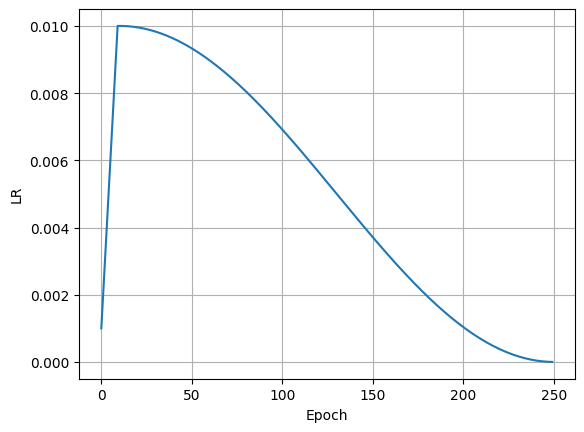

In [26]:
import matplotlib.pyplot as plt

scheduler = CosineScheduler(epochs=250, warmup_length=10, lr=0.01)
x = np.arange(250)
plt.plot(x, [scheduler(epoch) for epoch in x])
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.grid(True)

plt.show()

学習率変更関数

In [27]:
def set_lr(lr, optimizer):
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [28]:
# ハイパーパラメータの設定
config = {
    "image_size": [48, 48],
    "patch_size": [6, 6],
    "emb_dim": 128,
    "enc_layers": 12,
    "enc_heads": 4,
    "enc_dim_head": 128,
    "enc_mlp_dim": 128,
    "dec_layers": 4,
    "dec_heads": 4,
    "dec_dim_head": 64,
    "dec_mlp_dim": 64,
    "mask_ratio": 0.75,
    "dropout": 0.
}

In [29]:
# モデルの定義
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MAE_ViT(**config).to(device)
epochs = 250
lr = 0.024
warmup_length=int(epochs*0.05)
#batch_size = 512
optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=0.05)
scheduler = CosineScheduler(epochs, lr, warmup_length)
step_count = 0

### 事前学習（自己教師あり学習）

In [30]:
model_path="./model/pretrain_01.pth"
model_w_path="./model/pretrain_w_01.pth"

In [31]:
run_1st=True
if run_1st==True:
    for epoch in range(epochs):
        # スケジューラで学習率を更新する
        new_lr = scheduler(epoch)
        set_lr(new_lr, optimizer)

        total_train_loss = 0.
        total_valid_loss = 0.

        scaler = torch.cuda.amp.GradScaler()  # added
        # モデルの訓練
        for x, _ in tqdm(dataloader_train, desc="Train"):
            step_count += 1
            model.train()
            x = x.to(device)

            with torch.cuda.amp.autocast():  # added
                rec_img, mask = model(x)
                train_loss = torch.mean((rec_img - x) ** 2 * mask) / config["mask_ratio"]

            #train_loss.backward()
            scaler.scale(train_loss).backward()

            #if step_count % 8 == 0:  # 8イテレーションごとに更新することで，擬似的にバッチサイズを大きくしている
            scaler.step(optimizer)
            #optimizer.step()
            optimizer.zero_grad()

            total_train_loss += train_loss.item()

            scaler.update()  #added

        # モデルの評価
        with torch.no_grad():
            for x, _ in tqdm(dataloader_valid, desc="Valid"):
                model.eval()

                with torch.no_grad():
                    x = x.to(device)

                    rec_img, mask = model(x)
                    valid_loss = torch.mean((rec_img - x) ** 2 * mask) / config["mask_ratio"]

                    total_valid_loss += valid_loss.item()


        print(f"Epoch[{epoch+1} / {epochs}] Train Loss: {total_train_loss/len(dataloader_train):.4f} Valid Loss: {total_valid_loss/len(dataloader_valid):.4f}")
        if epoch%50==0:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': total_train_loss,
                    'valid_loss': total_valid_loss,
                    }, model_w_path)
    # モデルを保存しておく
    torch.save(model.state_dict(), model_path)
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': total_train_loss,
            'valid_loss': total_valid_loss,
            }, model_w_path)

Valid: 100%|██████████| 12/12 [00:00<00:00, 17.57it/s]


Epoch[1 / 250] Train Loss: 0.2294 Valid Loss: 0.1891


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.58it/s]


Epoch[2 / 250] Train Loss: 0.2044 Valid Loss: 0.1874


Valid: 100%|██████████| 12/12 [00:00<00:00, 18.02it/s]


Epoch[3 / 250] Train Loss: 0.2213 Valid Loss: 0.1846


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.75it/s]


Epoch[4 / 250] Train Loss: 0.1845 Valid Loss: 0.1704


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.84it/s]


Epoch[5 / 250] Train Loss: 0.3394 Valid Loss: 0.6193


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.62it/s]


Epoch[6 / 250] Train Loss: 0.2894 Valid Loss: 0.2227


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.59it/s]


Epoch[7 / 250] Train Loss: 0.8601 Valid Loss: 0.2176


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.68it/s]


Epoch[8 / 250] Train Loss: 0.2260 Valid Loss: 0.2126


Valid: 100%|██████████| 12/12 [00:00<00:00, 18.05it/s]


Epoch[9 / 250] Train Loss: 2.6464 Valid Loss: 0.7163


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.39it/s]


Epoch[10 / 250] Train Loss: 0.2512 Valid Loss: 0.2091


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.35it/s]


Epoch[11 / 250] Train Loss: 1.6931 Valid Loss: 12.2129


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.63it/s]


Epoch[12 / 250] Train Loss: 7.5287 Valid Loss: 0.2393


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.55it/s]


Epoch[13 / 250] Train Loss: 0.2281 Valid Loss: 0.2194


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.46it/s]


Epoch[14 / 250] Train Loss: 6.4998 Valid Loss: 0.2601


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.31it/s]


Epoch[15 / 250] Train Loss: 1.1585 Valid Loss: 6.8551


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.63it/s]


Epoch[16 / 250] Train Loss: 5.4589 Valid Loss: 0.2927


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.14it/s]


Epoch[17 / 250] Train Loss: 0.2520 Valid Loss: 0.2178


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.55it/s]


Epoch[18 / 250] Train Loss: 0.7723 Valid Loss: 2.9716


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.56it/s]


Epoch[19 / 250] Train Loss: 3.2591 Valid Loss: 0.2892


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.99it/s]


Epoch[20 / 250] Train Loss: 0.2260 Valid Loss: 0.1883


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.32it/s]


Epoch[21 / 250] Train Loss: 0.1799 Valid Loss: 0.1610


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.39it/s]


Epoch[22 / 250] Train Loss: 2.1552 Valid Loss: 1.1026


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.31it/s]


Epoch[23 / 250] Train Loss: 0.3952 Valid Loss: 0.2052


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.04it/s]


Epoch[24 / 250] Train Loss: 0.1995 Valid Loss: 0.1804


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.52it/s]


Epoch[25 / 250] Train Loss: 0.1754 Valid Loss: 0.1516


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.57it/s]


Epoch[26 / 250] Train Loss: 0.1497 Valid Loss: 0.1516


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.55it/s]


Epoch[27 / 250] Train Loss: 0.8780 Valid Loss: 0.2404


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.57it/s]


Epoch[28 / 250] Train Loss: 0.1809 Valid Loss: 0.1524


Valid: 100%|██████████| 12/12 [00:00<00:00, 18.19it/s]


Epoch[29 / 250] Train Loss: 0.7541 Valid Loss: 0.6747


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.70it/s]


Epoch[30 / 250] Train Loss: 0.2624 Valid Loss: 0.1420


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.70it/s]


Epoch[31 / 250] Train Loss: 0.1443 Valid Loss: 0.1374


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.57it/s]


Epoch[32 / 250] Train Loss: 1.4872 Valid Loss: 0.3025


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.77it/s]


Epoch[33 / 250] Train Loss: 0.2215 Valid Loss: 0.1636


Valid: 100%|██████████| 12/12 [00:00<00:00, 18.09it/s]


Epoch[34 / 250] Train Loss: 0.9055 Valid Loss: 0.4133


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.56it/s]


Epoch[35 / 250] Train Loss: 0.2215 Valid Loss: 0.1606


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.99it/s]


Epoch[36 / 250] Train Loss: 0.1477 Valid Loss: 0.1435


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.57it/s]


Epoch[37 / 250] Train Loss: 1.9632 Valid Loss: 0.8208


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.57it/s]


Epoch[38 / 250] Train Loss: 0.3894 Valid Loss: 0.2616


Valid: 100%|██████████| 12/12 [00:00<00:00, 18.05it/s]


Epoch[39 / 250] Train Loss: 0.2290 Valid Loss: 0.2032


Valid: 100%|██████████| 12/12 [00:00<00:00, 18.00it/s]


Epoch[40 / 250] Train Loss: 0.7323 Valid Loss: 0.1681


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.88it/s]


Epoch[41 / 250] Train Loss: 0.1500 Valid Loss: 0.1392


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.63it/s]


Epoch[42 / 250] Train Loss: 0.2302 Valid Loss: 0.2398


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.51it/s]


Epoch[43 / 250] Train Loss: 0.4319 Valid Loss: 0.1403


Valid: 100%|██████████| 12/12 [00:00<00:00, 16.00it/s]


Epoch[44 / 250] Train Loss: 0.1387 Valid Loss: 0.1314


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.74it/s]


Epoch[45 / 250] Train Loss: 0.4552 Valid Loss: 0.9714


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.66it/s]


Epoch[46 / 250] Train Loss: 1.5711 Valid Loss: 0.2602


Valid: 100%|██████████| 12/12 [00:00<00:00, 18.13it/s]


Epoch[47 / 250] Train Loss: 0.1997 Valid Loss: 0.1491


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.51it/s]


Epoch[48 / 250] Train Loss: 0.2785 Valid Loss: 8.6343


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.44it/s]


Epoch[49 / 250] Train Loss: 0.9501 Valid Loss: 0.1843


Valid: 100%|██████████| 12/12 [00:00<00:00, 18.00it/s]


Epoch[50 / 250] Train Loss: 0.1517 Valid Loss: 0.1367


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.61it/s]


Epoch[51 / 250] Train Loss: 0.1669 Valid Loss: 0.3148


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.77it/s]


Epoch[52 / 250] Train Loss: 0.2950 Valid Loss: 0.1365


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.74it/s]


Epoch[53 / 250] Train Loss: 0.2983 Valid Loss: 0.3227


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.93it/s]


Epoch[54 / 250] Train Loss: 0.2332 Valid Loss: 0.1327


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.84it/s]


Epoch[55 / 250] Train Loss: 0.1347 Valid Loss: 0.1346


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.92it/s]


Epoch[56 / 250] Train Loss: 0.1417 Valid Loss: 0.1472


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.79it/s]


Epoch[57 / 250] Train Loss: 5.9711 Valid Loss: 0.5317


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.79it/s]


Epoch[58 / 250] Train Loss: 0.5089 Valid Loss: 0.2608


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.97it/s]


Epoch[59 / 250] Train Loss: 0.2225 Valid Loss: 0.1692


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.81it/s]


Epoch[60 / 250] Train Loss: 0.4197 Valid Loss: 0.2406


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.55it/s]


Epoch[61 / 250] Train Loss: 0.1732 Valid Loss: 0.1378


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.85it/s]


Epoch[62 / 250] Train Loss: 0.1682 Valid Loss: 1.2263


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.55it/s]


Epoch[63 / 250] Train Loss: 0.3920 Valid Loss: 0.1428


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.90it/s]


Epoch[64 / 250] Train Loss: 0.1379 Valid Loss: 0.1320


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.93it/s]


Epoch[65 / 250] Train Loss: 0.3665 Valid Loss: 1.2469


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.46it/s]


Epoch[66 / 250] Train Loss: 0.2377 Valid Loss: 0.1309


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.83it/s]


Epoch[67 / 250] Train Loss: 0.1365 Valid Loss: 0.1631


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.82it/s]


Epoch[68 / 250] Train Loss: 0.5593 Valid Loss: 0.1825


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.90it/s]


Epoch[69 / 250] Train Loss: 0.1564 Valid Loss: 0.1359


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.82it/s]


Epoch[70 / 250] Train Loss: 0.1845 Valid Loss: 0.1852


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.70it/s]


Epoch[71 / 250] Train Loss: 0.1480 Valid Loss: 0.1290


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.96it/s]


Epoch[72 / 250] Train Loss: 0.1891 Valid Loss: 0.2318


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.84it/s]


Epoch[73 / 250] Train Loss: 0.1593 Valid Loss: 0.1293


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.77it/s]


Epoch[74 / 250] Train Loss: 0.1329 Valid Loss: 0.1323


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.81it/s]


Epoch[75 / 250] Train Loss: 0.2697 Valid Loss: 0.1330


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.96it/s]


Epoch[76 / 250] Train Loss: 0.1324 Valid Loss: 0.1281


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.84it/s]


Epoch[77 / 250] Train Loss: 1.0721 Valid Loss: 0.4382


Valid: 100%|██████████| 12/12 [00:00<00:00, 12.01it/s]


Epoch[78 / 250] Train Loss: 0.4466 Valid Loss: 0.1468


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.96it/s]


Epoch[79 / 250] Train Loss: 0.1354 Valid Loss: 0.1292


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.88it/s]


Epoch[80 / 250] Train Loss: 0.2604 Valid Loss: 0.1556


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.76it/s]


Epoch[81 / 250] Train Loss: 0.1368 Valid Loss: 0.1283


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.81it/s]


Epoch[82 / 250] Train Loss: 0.1947 Valid Loss: 0.1541


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.99it/s]


Epoch[83 / 250] Train Loss: 0.1335 Valid Loss: 0.1284


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.99it/s]


Epoch[84 / 250] Train Loss: 0.1592 Valid Loss: 0.1347


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.88it/s]


Epoch[85 / 250] Train Loss: 0.1317 Valid Loss: 0.1292


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.96it/s]


Epoch[86 / 250] Train Loss: 0.1459 Valid Loss: 0.1299


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.86it/s]


Epoch[87 / 250] Train Loss: 0.1324 Valid Loss: 0.1700


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.92it/s]


Epoch[88 / 250] Train Loss: 0.1363 Valid Loss: 0.1288


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.99it/s]


Epoch[89 / 250] Train Loss: 0.1496 Valid Loss: 0.1780


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.90it/s]


Epoch[90 / 250] Train Loss: 0.1465 Valid Loss: 0.1268


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.90it/s]


Epoch[91 / 250] Train Loss: 0.1307 Valid Loss: 0.1272


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.71it/s]


Epoch[92 / 250] Train Loss: 0.1461 Valid Loss: 0.1264


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.97it/s]


Epoch[93 / 250] Train Loss: 0.1346 Valid Loss: 0.1682


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.80it/s]


Epoch[94 / 250] Train Loss: 0.1932 Valid Loss: 0.1282


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.71it/s]


Epoch[95 / 250] Train Loss: 0.1303 Valid Loss: 0.1257


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.67it/s]


Epoch[96 / 250] Train Loss: 0.1317 Valid Loss: 0.1271


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.76it/s]


Epoch[97 / 250] Train Loss: 0.1373 Valid Loss: 0.1379


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.73it/s]


Epoch[98 / 250] Train Loss: 0.1304 Valid Loss: 0.1287


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.85it/s]


Epoch[99 / 250] Train Loss: 0.1309 Valid Loss: 0.1396


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.86it/s]


Epoch[100 / 250] Train Loss: 0.2582 Valid Loss: 0.1351


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.89it/s]


Epoch[101 / 250] Train Loss: 0.1282 Valid Loss: 0.1237


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.52it/s]


Epoch[102 / 250] Train Loss: 0.1487 Valid Loss: 0.1317


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.88it/s]


Epoch[103 / 250] Train Loss: 0.1256 Valid Loss: 0.1205


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.71it/s]


Epoch[104 / 250] Train Loss: 0.1325 Valid Loss: 0.1420


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.73it/s]


Epoch[105 / 250] Train Loss: 0.1278 Valid Loss: 0.1196


Valid: 100%|██████████| 12/12 [00:01<00:00, 10.61it/s]


Epoch[106 / 250] Train Loss: 0.1225 Valid Loss: 0.1198


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.80it/s]


Epoch[107 / 250] Train Loss: 0.1235 Valid Loss: 0.1167


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.98it/s]


Epoch[108 / 250] Train Loss: 0.1228 Valid Loss: 0.1618


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.94it/s]


Epoch[109 / 250] Train Loss: 0.1368 Valid Loss: 0.1162


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.63it/s]


Epoch[110 / 250] Train Loss: 0.1187 Valid Loss: 0.1145


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.90it/s]


Epoch[111 / 250] Train Loss: 0.1214 Valid Loss: 0.1453


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.68it/s]


Epoch[112 / 250] Train Loss: 0.1226 Valid Loss: 0.1135


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.79it/s]


Epoch[113 / 250] Train Loss: 0.1163 Valid Loss: 0.1130


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.96it/s]


Epoch[114 / 250] Train Loss: 0.1181 Valid Loss: 0.1129


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.97it/s]


Epoch[115 / 250] Train Loss: 0.1143 Valid Loss: 0.1114


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.81it/s]


Epoch[116 / 250] Train Loss: 0.1138 Valid Loss: 0.1144


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.86it/s]


Epoch[117 / 250] Train Loss: 0.1128 Valid Loss: 0.1083


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.97it/s]


Epoch[118 / 250] Train Loss: 0.1126 Valid Loss: 0.1109


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.90it/s]


Epoch[119 / 250] Train Loss: 0.1134 Valid Loss: 0.1092


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.92it/s]


Epoch[120 / 250] Train Loss: 0.1114 Valid Loss: 0.1094


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.94it/s]


Epoch[121 / 250] Train Loss: 0.1120 Valid Loss: 0.1074


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.92it/s]


Epoch[122 / 250] Train Loss: 0.1108 Valid Loss: 0.1066


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.93it/s]


Epoch[123 / 250] Train Loss: 0.1116 Valid Loss: 0.1112


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.84it/s]


Epoch[124 / 250] Train Loss: 0.1108 Valid Loss: 0.1061


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.92it/s]


Epoch[125 / 250] Train Loss: 0.1096 Valid Loss: 0.1078


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.82it/s]


Epoch[126 / 250] Train Loss: 0.1094 Valid Loss: 0.1062


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.91it/s]


Epoch[127 / 250] Train Loss: 0.1086 Valid Loss: 0.1052


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.93it/s]


Epoch[128 / 250] Train Loss: 0.1074 Valid Loss: 0.1056


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.86it/s]


Epoch[129 / 250] Train Loss: 0.1075 Valid Loss: 0.1062


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.86it/s]


Epoch[130 / 250] Train Loss: 0.1072 Valid Loss: 0.1053


Valid: 100%|██████████| 12/12 [00:01<00:00, 12.00it/s]


Epoch[131 / 250] Train Loss: 0.1070 Valid Loss: 0.1034


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.88it/s]


Epoch[132 / 250] Train Loss: 0.1068 Valid Loss: 0.1042


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.84it/s]


Epoch[133 / 250] Train Loss: 0.1066 Valid Loss: 0.1033


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.77it/s]


Epoch[134 / 250] Train Loss: 0.1060 Valid Loss: 0.1021


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.81it/s]


Epoch[135 / 250] Train Loss: 0.1052 Valid Loss: 0.1026


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.91it/s]


Epoch[136 / 250] Train Loss: 0.1055 Valid Loss: 0.1013


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.81it/s]


Epoch[137 / 250] Train Loss: 0.1050 Valid Loss: 0.1031


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.72it/s]


Epoch[138 / 250] Train Loss: 0.1042 Valid Loss: 0.1023


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.89it/s]


Epoch[139 / 250] Train Loss: 0.1044 Valid Loss: 0.1024


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.76it/s]


Epoch[140 / 250] Train Loss: 0.1039 Valid Loss: 0.1013


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.78it/s]


Epoch[141 / 250] Train Loss: 0.1038 Valid Loss: 0.1017


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.82it/s]


Epoch[142 / 250] Train Loss: 0.1031 Valid Loss: 0.1012


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.77it/s]


Epoch[143 / 250] Train Loss: 0.1029 Valid Loss: 0.1003


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.92it/s]


Epoch[144 / 250] Train Loss: 0.1030 Valid Loss: 0.0994


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.97it/s]


Epoch[145 / 250] Train Loss: 0.1025 Valid Loss: 0.1011


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.93it/s]


Epoch[146 / 250] Train Loss: 0.1018 Valid Loss: 0.0987


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.80it/s]


Epoch[147 / 250] Train Loss: 0.1016 Valid Loss: 0.0978


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.69it/s]


Epoch[148 / 250] Train Loss: 0.1008 Valid Loss: 0.0994


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.92it/s]


Epoch[149 / 250] Train Loss: 0.1010 Valid Loss: 0.0979


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.94it/s]


Epoch[150 / 250] Train Loss: 0.1004 Valid Loss: 0.0977


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.99it/s]


Epoch[151 / 250] Train Loss: 0.1003 Valid Loss: 0.0979


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.94it/s]


Epoch[152 / 250] Train Loss: 0.0997 Valid Loss: 0.0987


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.83it/s]


Epoch[153 / 250] Train Loss: 0.0999 Valid Loss: 0.0976


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.96it/s]


Epoch[154 / 250] Train Loss: 0.0998 Valid Loss: 0.0972


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.84it/s]


Epoch[155 / 250] Train Loss: 0.0999 Valid Loss: 0.0970


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.86it/s]


Epoch[156 / 250] Train Loss: 0.0997 Valid Loss: 0.0963


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.97it/s]


Epoch[157 / 250] Train Loss: 0.0994 Valid Loss: 0.0973


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.98it/s]


Epoch[158 / 250] Train Loss: 0.0990 Valid Loss: 0.0959


Valid: 100%|██████████| 12/12 [00:00<00:00, 12.00it/s]


Epoch[159 / 250] Train Loss: 0.0990 Valid Loss: 0.0961


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.86it/s]


Epoch[160 / 250] Train Loss: 0.0984 Valid Loss: 0.0970


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.95it/s]


Epoch[161 / 250] Train Loss: 0.0980 Valid Loss: 0.0968


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.95it/s]


Epoch[162 / 250] Train Loss: 0.0981 Valid Loss: 0.0954


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.89it/s]


Epoch[163 / 250] Train Loss: 0.0979 Valid Loss: 0.0952


Valid: 100%|██████████| 12/12 [00:00<00:00, 12.00it/s]


Epoch[164 / 250] Train Loss: 0.0978 Valid Loss: 0.0958


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.74it/s]


Epoch[165 / 250] Train Loss: 0.0977 Valid Loss: 0.0960


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.92it/s]


Epoch[166 / 250] Train Loss: 0.0974 Valid Loss: 0.0956


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.53it/s]


Epoch[167 / 250] Train Loss: 0.0972 Valid Loss: 0.0946


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.72it/s]


Epoch[168 / 250] Train Loss: 0.0970 Valid Loss: 0.0950


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.78it/s]


Epoch[169 / 250] Train Loss: 0.0966 Valid Loss: 0.0944


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.88it/s]


Epoch[170 / 250] Train Loss: 0.0966 Valid Loss: 0.0939


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.70it/s]


Epoch[171 / 250] Train Loss: 0.0965 Valid Loss: 0.0940


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.89it/s]


Epoch[172 / 250] Train Loss: 0.0960 Valid Loss: 0.0930


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.69it/s]


Epoch[173 / 250] Train Loss: 0.0961 Valid Loss: 0.0949


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.83it/s]


Epoch[174 / 250] Train Loss: 0.0961 Valid Loss: 0.0939


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.79it/s]


Epoch[175 / 250] Train Loss: 0.0959 Valid Loss: 0.0931


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.52it/s]


Epoch[176 / 250] Train Loss: 0.0955 Valid Loss: 0.0943


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.61it/s]


Epoch[177 / 250] Train Loss: 0.0953 Valid Loss: 0.0928


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.69it/s]


Epoch[178 / 250] Train Loss: 0.0955 Valid Loss: 0.0935


Valid: 100%|██████████| 12/12 [00:01<00:00, 11.90it/s]


Epoch[179 / 250] Train Loss: 0.0947 Valid Loss: 0.0935


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.19it/s]


Epoch[180 / 250] Train Loss: 0.0948 Valid Loss: 0.0921


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.57it/s]


Epoch[181 / 250] Train Loss: 0.0948 Valid Loss: 0.0932


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.81it/s]


Epoch[182 / 250] Train Loss: 0.0945 Valid Loss: 0.0945


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.69it/s]


Epoch[183 / 250] Train Loss: 0.0945 Valid Loss: 0.0928


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.95it/s]


Epoch[184 / 250] Train Loss: 0.0941 Valid Loss: 0.0919


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.54it/s]


Epoch[185 / 250] Train Loss: 0.0942 Valid Loss: 0.0931


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.49it/s]


Epoch[186 / 250] Train Loss: 0.0940 Valid Loss: 0.0916


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.26it/s]


Epoch[187 / 250] Train Loss: 0.0940 Valid Loss: 0.0931


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.58it/s]


Epoch[188 / 250] Train Loss: 0.0935 Valid Loss: 0.0924


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.20it/s]


Epoch[189 / 250] Train Loss: 0.0938 Valid Loss: 0.0916


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.64it/s]


Epoch[190 / 250] Train Loss: 0.0935 Valid Loss: 0.0910


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.56it/s]


Epoch[191 / 250] Train Loss: 0.0933 Valid Loss: 0.0917


Valid: 100%|██████████| 12/12 [00:00<00:00, 18.10it/s]


Epoch[192 / 250] Train Loss: 0.0932 Valid Loss: 0.0906


Valid: 100%|██████████| 12/12 [00:00<00:00, 18.03it/s]


Epoch[193 / 250] Train Loss: 0.0931 Valid Loss: 0.0912


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.48it/s]


Epoch[194 / 250] Train Loss: 0.0925 Valid Loss: 0.0912


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.56it/s]


Epoch[195 / 250] Train Loss: 0.0927 Valid Loss: 0.0916


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.14it/s]


Epoch[196 / 250] Train Loss: 0.0931 Valid Loss: 0.0906


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.89it/s]


Epoch[197 / 250] Train Loss: 0.0925 Valid Loss: 0.0925


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.95it/s]


Epoch[198 / 250] Train Loss: 0.0926 Valid Loss: 0.0897


Valid: 100%|██████████| 12/12 [00:00<00:00, 18.00it/s]


Epoch[199 / 250] Train Loss: 0.0919 Valid Loss: 0.0912


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.51it/s]


Epoch[200 / 250] Train Loss: 0.0918 Valid Loss: 0.0904


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.56it/s]


Epoch[201 / 250] Train Loss: 0.0917 Valid Loss: 0.0903


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.56it/s]


Epoch[202 / 250] Train Loss: 0.0919 Valid Loss: 0.0904


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.93it/s]


Epoch[203 / 250] Train Loss: 0.0917 Valid Loss: 0.0895


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.82it/s]


Epoch[204 / 250] Train Loss: 0.0913 Valid Loss: 0.0892


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.58it/s]


Epoch[205 / 250] Train Loss: 0.0916 Valid Loss: 0.0894


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.66it/s]


Epoch[206 / 250] Train Loss: 0.0913 Valid Loss: 0.0892


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.56it/s]


Epoch[207 / 250] Train Loss: 0.0909 Valid Loss: 0.0896


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.58it/s]


Epoch[208 / 250] Train Loss: 0.0909 Valid Loss: 0.0900


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.15it/s]


Epoch[209 / 250] Train Loss: 0.0907 Valid Loss: 0.0896


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.37it/s]


Epoch[210 / 250] Train Loss: 0.0906 Valid Loss: 0.0889


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.80it/s]


Epoch[211 / 250] Train Loss: 0.0904 Valid Loss: 0.0884


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.35it/s]


Epoch[212 / 250] Train Loss: 0.0903 Valid Loss: 0.0894


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.19it/s]


Epoch[213 / 250] Train Loss: 0.0901 Valid Loss: 0.0886


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.29it/s]


Epoch[214 / 250] Train Loss: 0.0902 Valid Loss: 0.0883


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.68it/s]


Epoch[215 / 250] Train Loss: 0.0899 Valid Loss: 0.0887


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.20it/s]


Epoch[216 / 250] Train Loss: 0.0899 Valid Loss: 0.0879


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.48it/s]


Epoch[217 / 250] Train Loss: 0.0899 Valid Loss: 0.0881


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.54it/s]


Epoch[218 / 250] Train Loss: 0.0896 Valid Loss: 0.0879


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.86it/s]


Epoch[219 / 250] Train Loss: 0.0891 Valid Loss: 0.0877


Valid: 100%|██████████| 12/12 [00:00<00:00, 18.00it/s]


Epoch[220 / 250] Train Loss: 0.0892 Valid Loss: 0.0874


Valid: 100%|██████████| 12/12 [00:00<00:00, 18.00it/s]


Epoch[221 / 250] Train Loss: 0.0889 Valid Loss: 0.0872


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.99it/s]


Epoch[222 / 250] Train Loss: 0.0890 Valid Loss: 0.0875


Valid: 100%|██████████| 12/12 [00:00<00:00, 18.01it/s]


Epoch[223 / 250] Train Loss: 0.0890 Valid Loss: 0.0880


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.57it/s]


Epoch[224 / 250] Train Loss: 0.0890 Valid Loss: 0.0876


Valid: 100%|██████████| 12/12 [00:00<00:00, 18.22it/s]


Epoch[225 / 250] Train Loss: 0.0892 Valid Loss: 0.0875


Valid: 100%|██████████| 12/12 [00:00<00:00, 18.00it/s]


Epoch[226 / 250] Train Loss: 0.0887 Valid Loss: 0.0880


Valid: 100%|██████████| 12/12 [00:00<00:00, 16.63it/s]


Epoch[227 / 250] Train Loss: 0.0885 Valid Loss: 0.0880


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.68it/s]


Epoch[228 / 250] Train Loss: 0.0882 Valid Loss: 0.0874


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.99it/s]


Epoch[229 / 250] Train Loss: 0.0885 Valid Loss: 0.0869


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.87it/s]


Epoch[230 / 250] Train Loss: 0.0882 Valid Loss: 0.0878


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.99it/s]


Epoch[231 / 250] Train Loss: 0.0885 Valid Loss: 0.0871


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.49it/s]


Epoch[232 / 250] Train Loss: 0.0882 Valid Loss: 0.0865


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.54it/s]


Epoch[233 / 250] Train Loss: 0.0882 Valid Loss: 0.0860


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.56it/s]


Epoch[234 / 250] Train Loss: 0.0880 Valid Loss: 0.0871


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.88it/s]


Epoch[235 / 250] Train Loss: 0.0877 Valid Loss: 0.0870


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.48it/s]


Epoch[236 / 250] Train Loss: 0.0878 Valid Loss: 0.0866


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.57it/s]


Epoch[237 / 250] Train Loss: 0.0878 Valid Loss: 0.0861


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.56it/s]


Epoch[238 / 250] Train Loss: 0.0877 Valid Loss: 0.0861


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.51it/s]


Epoch[239 / 250] Train Loss: 0.0878 Valid Loss: 0.0862


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.27it/s]


Epoch[240 / 250] Train Loss: 0.0878 Valid Loss: 0.0861


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.54it/s]


Epoch[241 / 250] Train Loss: 0.0875 Valid Loss: 0.0867


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.92it/s]


Epoch[242 / 250] Train Loss: 0.0877 Valid Loss: 0.0865


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.99it/s]


Epoch[243 / 250] Train Loss: 0.0877 Valid Loss: 0.0866


Valid: 100%|██████████| 12/12 [00:00<00:00, 18.06it/s]


Epoch[244 / 250] Train Loss: 0.0878 Valid Loss: 0.0866


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.52it/s]


Epoch[245 / 250] Train Loss: 0.0872 Valid Loss: 0.0865


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.64it/s]


Epoch[246 / 250] Train Loss: 0.0876 Valid Loss: 0.0860


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.57it/s]


Epoch[247 / 250] Train Loss: 0.0875 Valid Loss: 0.0857


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.12it/s]


Epoch[248 / 250] Train Loss: 0.0873 Valid Loss: 0.0863


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.89it/s]


Epoch[249 / 250] Train Loss: 0.0873 Valid Loss: 0.0858


Valid: 100%|██████████| 12/12 [00:00<00:00, 17.64it/s]


Epoch[250 / 250] Train Loss: 0.0877 Valid Loss: 0.0869


restart

In [32]:
run_2nd=False
if run_2nd==True:
    model = MAE_ViT(**config).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=0.05)

    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    t_loss = checkpoint['train_loss']
    v_loss = checkpoint['valid_loss']

    for epoch in range(epoch, epochs):
        # スケジューラで学習率を更新する
        new_lr = scheduler(epoch)
        set_lr(new_lr, optimizer)

        total_train_loss = 0.
        total_valid_loss = 0.

        scaler = torch.cuda.amp.GradScaler()  # added
        # モデルの訓練
        for x, _ in dataloader_train:
            step_count += 1
            model.train()
            x = x.to(device)

            with torch.cuda.amp.autocast():  # added
                rec_img, mask = model(x)
                train_loss = torch.mean((rec_img - x) ** 2 * mask) / config["mask_ratio"]

            #train_loss.backward()
            scaler.scale(train_loss).backward()

            #if step_count % 8 == 0:  # 8イテレーションごとに更新することで，擬似的にバッチサイズを大きくしている
            scaler.step(optimizer)
            #optimizer.step()
            optimizer.zero_grad()

            total_train_loss += train_loss.item()

            scaler.update()

        # モデルの評価
        with torch.no_grad():
            for x, _ in dataloader_valid:
                model.eval()

                with torch.no_grad():
                    x = x.to(device)

                    rec_img, mask = model(x)
                    valid_loss = torch.mean((rec_img - x) ** 2 * mask) / config["mask_ratio"]

                    total_valid_loss += valid_loss.item()


        print(f"Epoch[{epoch+1} / {epochs}] Train Loss: {total_train_loss/len(dataloader_train):.4f} Valid Loss: {total_valid_loss/len(dataloader_valid):.4f}")
        if epoch%50==0:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': total_train_loss,
                    'valid_loss': total_valid_loss,
                    }, model_w_path)
    # モデルを保存しておく
    torch.save(model.state_dict(), model_path)
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': total_train_loss,
            'valid_loss': total_valid_loss,
            }, model_w_path)


保存したモデルで推論

In [33]:
model = MAE_ViT(**config).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

model.eval()
x, _ = next(iter(dataloader_valid))
with torch.no_grad():
    rec_img, mask = model(x.to(device))

x, rec_img, mask = x.to("cpu"), rec_img.to("cpu"), mask.to("cpu")

推論結果の描画

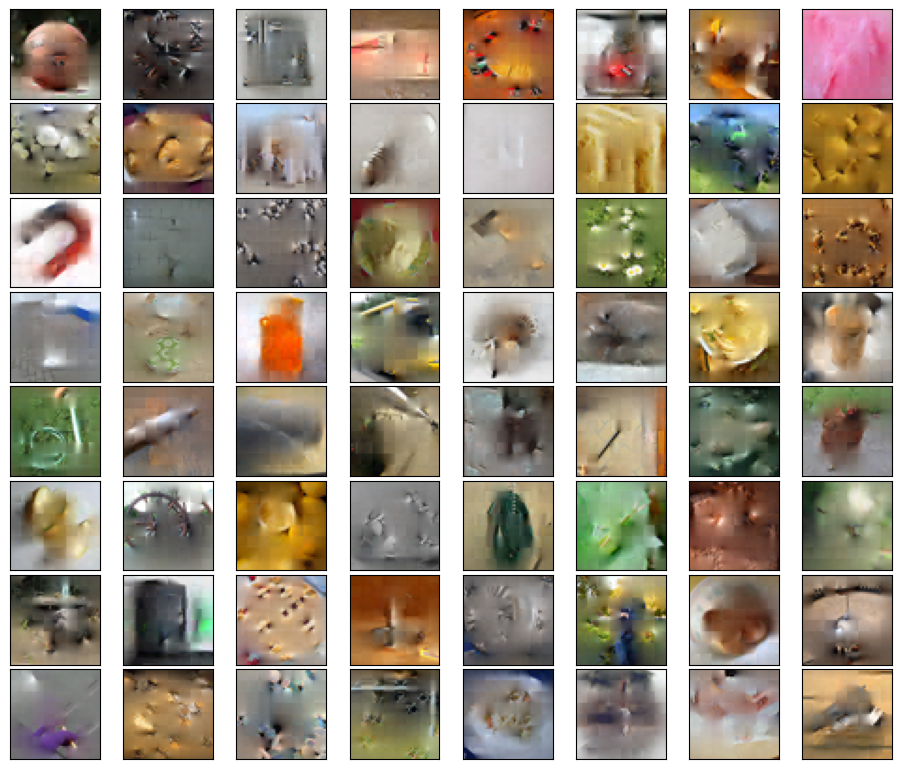

In [34]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

# MAEの出力そのままを可視化する場合
# imgs = rec_img

# マスクしていた部分は元の画像を用いる
imgs = rec_img * mask + x * (1 - mask)
imgs = (imgs.data + 1) / 2  # 標準化した状態から0-1に戻す
i = 0
for img in imgs[:64]:
    # 出力が線形変換のため0-1になっているとは限らないためclipする
    img = np.clip(np.transpose(torch.squeeze(img).numpy(), (1, 2, 0)), 0, 1)
    ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
    ax.imshow(img)
    i += 1

元画像の描画

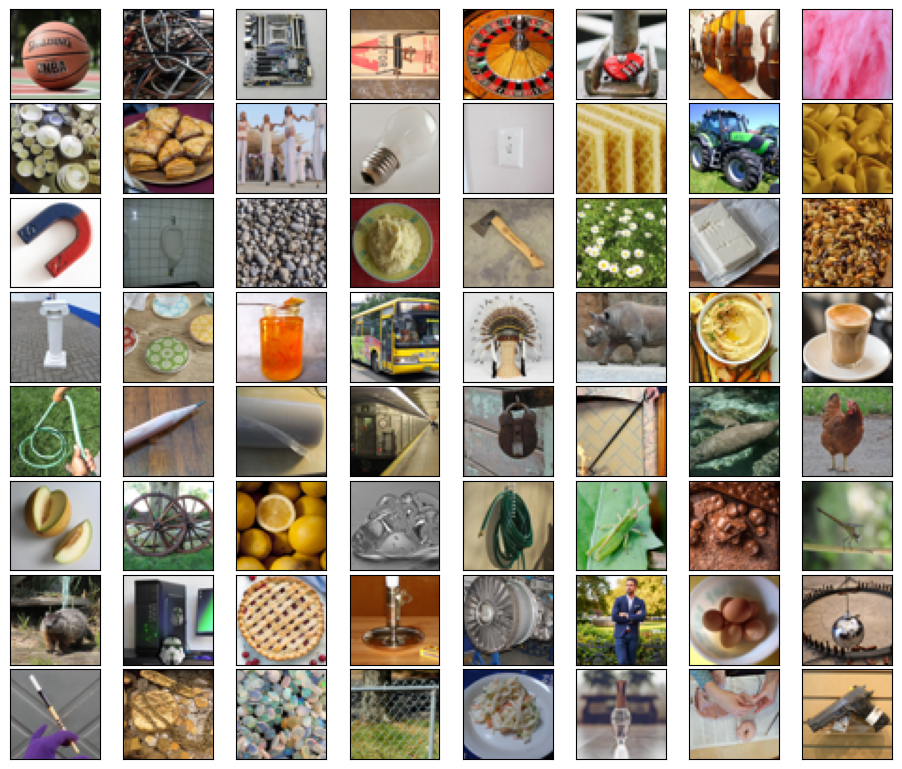

In [35]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

i = 0
imgs = (x.data + 1) / 2
for img in imgs[:64]:
    img = np.clip(np.transpose(torch.squeeze(img).numpy(), (1, 2, 0)), 0, 1)
    ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
    ax.imshow(img)
    i += 1

Attention mapの可視化

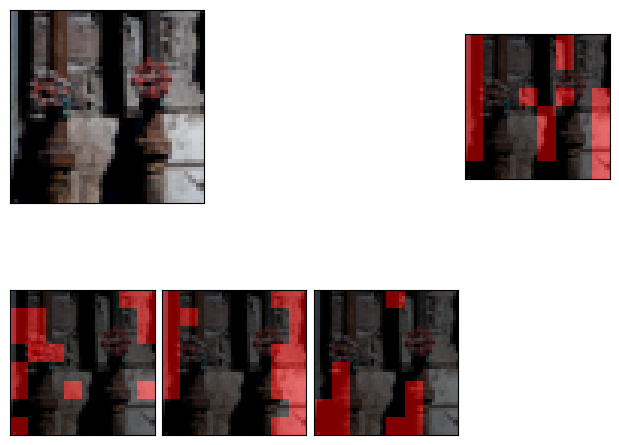

In [37]:
def display_attn_map(model, x):
    # Encoderの最後のattention mapを取得
    attn = model.get_last_selfattention(x[0].unsqueeze(0).to(device))

    # Nはパッチの数
    # (1, num_head, N+1, N+1) -> (num_head, N)
    num_head = config["enc_heads"]
    attn = attn[0, :, 0, 1:].reshape(num_head, -1)  # cls tokenに対するスコアを抽出

    val, idx = torch.sort(attn)  # スコアを昇順でソート
    val /= torch.sum(val, dim=1, keepdim=True)  # スコアを[0-1]で正規化する

    # 累積和をとりスコアの合計が0.6ほどになるように残す
    cumval = torch.cumsum(val, dim=1)
    attn = cumval > (1 - 0.4)
    backward_indexes = torch.argsort(idx)

    # ソートしたものを戻す
    for head in range(num_head):
        attn[head] = attn[head][backward_indexes[head]]

    # スコアを画像の形にする
    w_featmap, h_featmap = config["image_size"][0] // config["patch_size"][0], config["image_size"][1] // config["patch_size"][1]
    attn = attn.reshape(num_head, h_featmap, w_featmap).float()

    # 入力画像と同じ大きさにする
    attn = nn.functional.interpolate(attn.unsqueeze(0), scale_factor=config["patch_size"][0], mode="nearest")[0].detach().cpu().numpy()

    # 入力画像とヘッドごとのattention mapを出力する
    fig = plt.figure(figsize=(6, 10))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                        wspace=0.05)

    img = (x[0].data + 1) / 2
    img = np.clip(np.transpose(torch.squeeze(img).numpy(), (1, 2, 0)), 0, 1)
    ax = fig.add_subplot(2, 3, 1, xticks=[], yticks=[])
    ax.imshow(img)

    for i in range(len(attn)):
        featmap = attn[i]
        featmap = np.concatenate((featmap[:,:,np.newaxis], np.zeros((48, 48, 2))), axis=2)
        ax = fig.add_subplot(2, 4, i+4, xticks=[], yticks=[])
        ax.imshow(img)
        ax.imshow(featmap, alpha=0.5)


model = MAE_ViT(**config).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
x, _ = next(iter(dataloader_valid))  # 検証用データからデータを取得する

display_attn_map(model, x)

### Linear probing

In [47]:
val_size = 3000
train_data, valid_data = torch.utils.data.random_split(image_dataset, [len(image_dataset) - val_size, val_size])

train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
valid_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

#trainval_data.transform=valid_transform
image_dataset.transform=valid_transform

batch_size = 256

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True
)

dataloader_valid = torch.utils.data.DataLoader(
    valid_data,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True
)


クラス分類器

In [48]:
class Classifier(nn.Module):
    def __init__(self, encoder: MAE_Encoder, num_classes=1854):
        super().__init__()
        self.cls_token = encoder.cls_token
        self.pos_embedding = encoder.pos_embedding
        self.patchify = encoder.patchify
        self.transformer = encoder.transformer
        self.layer_norm = encoder.layer_norm
        self.head = nn.Linear(self.pos_embedding.shape[-1], num_classes)

    def forward(self, img):
        patches = self.patchify(img)
        patches = patches + self.pos_embedding  # positional embedding

        patches = torch.cat([self.cls_token.repeat(patches.shape[0], 1, 1), patches], dim=1)  # class tokenを結合
        features = self.layer_norm(self.transformer(patches))
        logits = self.head(features[:, 0])  # cls tokenのみを入力する
        return logits

    def get_last_selfattention(self, x):
        patches = self.patchify(x)
        patches = patches + self.pos_embedding

        patches = torch.cat([self.cls_token.repeat(patches.shape[0], 1, 1), patches], dim=1)  # class tokenを結合
        for i, block in enumerate(self.transformer):
            if i < len(self.transformer) - 1:
                patches = block(patches)
            else:
                return block(patches, return_attn=True)

In [49]:
# ハイパーパラメータの設定
config = {
    "image_size": [48, 48],
    "patch_size": [6, 6],
    "emb_dim": 128,
    "enc_layers": 12,
    "enc_heads": 4,
    "enc_dim_head": 128,
    "enc_mlp_dim": 128,
    "dec_layers": 4,
    "dec_heads": 4,
    "dec_dim_head": 64,
    "dec_mlp_dim": 64,
    "mask_ratio": 0.75,
    "dropout": 0.
}

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"
pretrained_model = MAE_ViT(**config).to(device)
pretrained_model.load_state_dict(torch.load(model_path, map_location=device))


encoder = pretrained_model.encoder

# モデルの定義
model = Classifier(encoder).to(device)

epochs = 100
lr = 0.005
warmup_length = int(epochs*0.05)
#batch_size = 128
optimizer = optim.AdamW(model.head.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0.05)  # 分類器部分のみ学習
scheduler = CosineScheduler(epochs, lr, warmup_length)
criterion = nn.CrossEntropyLoss()

分類器の学習

In [51]:
class_path="./model/classifier_01.pth"

In [52]:
for epoch in range(epochs):
    new_lr = scheduler(epoch)
    set_lr(new_lr, optimizer)

    total_train_loss = 0.
    total_train_acc = 0.
    total_valid_loss = 0.
    total_valid_acc = 0.

    scaler = torch.cuda.amp.GradScaler()  # added
    for x, t in tqdm(dataloader_train, desc="Train"):
        x, t = x.to(device), t.to(device)
        with torch.cuda.amp.autocast():  # added
            pred = model(x)
            train_loss = criterion(pred, t)

        train_acc = (torch.argmax(pred, dim=1) == t).float().mean().cpu()

        optimizer.zero_grad()
        #train_loss.backward()
        scaler.scale(train_loss).backward()

        #optimizer.step()
        scaler.step(optimizer)

        total_train_loss += train_loss.item()
        total_train_acc += train_acc

        scaler.update()

    with torch.no_grad():
        for x, t in dataloader_valid:
            x, t = x.to(device), t.to(device)
            pred = model(x)

            valid_loss = criterion(pred, t)
            valid_acc = (torch.argmax(pred, dim=1) == t).float().mean().cpu()

            total_valid_loss += valid_loss.item()
            total_valid_acc += valid_acc

    print(f"Epoch[{epoch+1} / {epochs}]",
          f"Train Loss: {total_train_loss/len(dataloader_train):.4f}",
          f"Train Acc.: {total_train_acc/len(dataloader_train):.4f}",
          f"Valid Loss: {total_valid_loss/len(dataloader_valid):.4f}",
          f"Valid Acc.: {total_valid_acc/len(dataloader_valid):.4f}")

torch.save(model.state_dict(), class_path)

Train: 100%|██████████| 76/76 [00:10<00:00,  7.12it/s]


Epoch[1 / 100] Train Loss: 7.5398 Train Acc.: 0.0006 Valid Loss: 7.5415 Valid Acc.: 0.0007


Train: 100%|██████████| 76/76 [00:09<00:00,  7.94it/s]


Epoch[2 / 100] Train Loss: 7.5255 Train Acc.: 0.0006 Valid Loss: 7.5522 Valid Acc.: 0.0000


Train: 100%|██████████| 76/76 [00:09<00:00,  7.86it/s]


Epoch[3 / 100] Train Loss: 7.5094 Train Acc.: 0.0011 Valid Loss: 7.5564 Valid Acc.: 0.0000


Train: 100%|██████████| 76/76 [00:09<00:00,  7.92it/s]


Epoch[4 / 100] Train Loss: 7.4890 Train Acc.: 0.0026 Valid Loss: 7.5464 Valid Acc.: 0.0000


Train: 100%|██████████| 76/76 [00:09<00:00,  7.88it/s]


Epoch[5 / 100] Train Loss: 7.4627 Train Acc.: 0.0037 Valid Loss: 7.5239 Valid Acc.: 0.0013


Train: 100%|██████████| 76/76 [00:09<00:00,  7.88it/s]


Epoch[6 / 100] Train Loss: 7.4258 Train Acc.: 0.0076 Valid Loss: 7.5002 Valid Acc.: 0.0013


Train: 100%|██████████| 76/76 [00:09<00:00,  7.90it/s]


Epoch[7 / 100] Train Loss: 7.3915 Train Acc.: 0.0106 Valid Loss: 7.4738 Valid Acc.: 0.0033


Train: 100%|██████████| 76/76 [00:09<00:00,  7.89it/s]


Epoch[8 / 100] Train Loss: 7.3578 Train Acc.: 0.0123 Valid Loss: 7.4502 Valid Acc.: 0.0051


Train: 100%|██████████| 76/76 [00:09<00:00,  7.94it/s]


Epoch[9 / 100] Train Loss: 7.3263 Train Acc.: 0.0129 Valid Loss: 7.4247 Valid Acc.: 0.0053


Train: 100%|██████████| 76/76 [00:09<00:00,  7.97it/s]


Epoch[10 / 100] Train Loss: 7.2963 Train Acc.: 0.0162 Valid Loss: 7.4027 Valid Acc.: 0.0053


Train: 100%|██████████| 76/76 [00:09<00:00,  7.93it/s]


Epoch[11 / 100] Train Loss: 7.2666 Train Acc.: 0.0193 Valid Loss: 7.3813 Valid Acc.: 0.0074


Train: 100%|██████████| 76/76 [00:09<00:00,  7.94it/s]


Epoch[12 / 100] Train Loss: 7.2379 Train Acc.: 0.0212 Valid Loss: 7.3610 Valid Acc.: 0.0075


Train: 100%|██████████| 76/76 [00:09<00:00,  7.96it/s]


Epoch[13 / 100] Train Loss: 7.2119 Train Acc.: 0.0218 Valid Loss: 7.3416 Valid Acc.: 0.0083


Train: 100%|██████████| 76/76 [00:09<00:00,  7.92it/s]


Epoch[14 / 100] Train Loss: 7.1861 Train Acc.: 0.0227 Valid Loss: 7.3237 Valid Acc.: 0.0086


Train: 100%|██████████| 76/76 [00:09<00:00,  7.97it/s]


Epoch[15 / 100] Train Loss: 7.1607 Train Acc.: 0.0259 Valid Loss: 7.3059 Valid Acc.: 0.0085


Train: 100%|██████████| 76/76 [00:09<00:00,  7.94it/s]


Epoch[16 / 100] Train Loss: 7.1367 Train Acc.: 0.0284 Valid Loss: 7.2874 Valid Acc.: 0.0107


Train: 100%|██████████| 76/76 [00:09<00:00,  7.94it/s]


Epoch[17 / 100] Train Loss: 7.1148 Train Acc.: 0.0299 Valid Loss: 7.2697 Valid Acc.: 0.0092


Train: 100%|██████████| 76/76 [00:14<00:00,  5.26it/s]


Epoch[18 / 100] Train Loss: 7.0934 Train Acc.: 0.0305 Valid Loss: 7.2550 Valid Acc.: 0.0089


Train: 100%|██████████| 76/76 [00:14<00:00,  5.25it/s]


Epoch[19 / 100] Train Loss: 7.0720 Train Acc.: 0.0288 Valid Loss: 7.2406 Valid Acc.: 0.0109


Train: 100%|██████████| 76/76 [00:14<00:00,  5.20it/s]


Epoch[20 / 100] Train Loss: 7.0522 Train Acc.: 0.0313 Valid Loss: 7.2271 Valid Acc.: 0.0118


Train: 100%|██████████| 76/76 [00:14<00:00,  5.18it/s]


Epoch[21 / 100] Train Loss: 7.0327 Train Acc.: 0.0329 Valid Loss: 7.2134 Valid Acc.: 0.0114


Train: 100%|██████████| 76/76 [00:14<00:00,  5.23it/s]


Epoch[22 / 100] Train Loss: 7.0147 Train Acc.: 0.0338 Valid Loss: 7.1985 Valid Acc.: 0.0114


Train: 100%|██████████| 76/76 [00:14<00:00,  5.25it/s]


Epoch[23 / 100] Train Loss: 6.9971 Train Acc.: 0.0345 Valid Loss: 7.1876 Valid Acc.: 0.0121


Train: 100%|██████████| 76/76 [00:14<00:00,  5.29it/s]


Epoch[24 / 100] Train Loss: 6.9790 Train Acc.: 0.0395 Valid Loss: 7.1756 Valid Acc.: 0.0106


Train: 100%|██████████| 76/76 [00:14<00:00,  5.22it/s]


Epoch[25 / 100] Train Loss: 6.9639 Train Acc.: 0.0352 Valid Loss: 7.1624 Valid Acc.: 0.0128


Train: 100%|██████████| 76/76 [00:14<00:00,  5.26it/s]


Epoch[26 / 100] Train Loss: 6.9481 Train Acc.: 0.0377 Valid Loss: 7.1545 Valid Acc.: 0.0120


Train: 100%|██████████| 76/76 [00:14<00:00,  5.25it/s]


Epoch[27 / 100] Train Loss: 6.9326 Train Acc.: 0.0416 Valid Loss: 7.1443 Valid Acc.: 0.0115


Train: 100%|██████████| 76/76 [00:14<00:00,  5.26it/s]


Epoch[28 / 100] Train Loss: 6.9193 Train Acc.: 0.0391 Valid Loss: 7.1338 Valid Acc.: 0.0141


Train: 100%|██████████| 76/76 [00:14<00:00,  5.23it/s]


Epoch[29 / 100] Train Loss: 6.9049 Train Acc.: 0.0407 Valid Loss: 7.1249 Valid Acc.: 0.0146


Train: 100%|██████████| 76/76 [00:14<00:00,  5.19it/s]


Epoch[30 / 100] Train Loss: 6.8923 Train Acc.: 0.0438 Valid Loss: 7.1156 Valid Acc.: 0.0122


Train: 100%|██████████| 76/76 [00:14<00:00,  5.20it/s]


Epoch[31 / 100] Train Loss: 6.8795 Train Acc.: 0.0436 Valid Loss: 7.1078 Valid Acc.: 0.0158


Train: 100%|██████████| 76/76 [00:14<00:00,  5.27it/s]


Epoch[32 / 100] Train Loss: 6.8667 Train Acc.: 0.0443 Valid Loss: 7.0959 Valid Acc.: 0.0152


Train: 100%|██████████| 76/76 [00:14<00:00,  5.25it/s]


Epoch[33 / 100] Train Loss: 6.8557 Train Acc.: 0.0426 Valid Loss: 7.0904 Valid Acc.: 0.0149


Train: 100%|██████████| 76/76 [00:14<00:00,  5.24it/s]


Epoch[34 / 100] Train Loss: 6.8440 Train Acc.: 0.0476 Valid Loss: 7.0835 Valid Acc.: 0.0148


Train: 100%|██████████| 76/76 [00:14<00:00,  5.23it/s]


Epoch[35 / 100] Train Loss: 6.8338 Train Acc.: 0.0467 Valid Loss: 7.0774 Valid Acc.: 0.0146


Train: 100%|██████████| 76/76 [00:14<00:00,  5.24it/s]


Epoch[36 / 100] Train Loss: 6.8232 Train Acc.: 0.0472 Valid Loss: 7.0679 Valid Acc.: 0.0191


Train: 100%|██████████| 76/76 [00:14<00:00,  5.29it/s]


Epoch[37 / 100] Train Loss: 6.8136 Train Acc.: 0.0478 Valid Loss: 7.0590 Valid Acc.: 0.0145


Train: 100%|██████████| 76/76 [00:14<00:00,  5.25it/s]


Epoch[38 / 100] Train Loss: 6.8037 Train Acc.: 0.0476 Valid Loss: 7.0557 Valid Acc.: 0.0154


Train: 100%|██████████| 76/76 [00:14<00:00,  5.18it/s]


Epoch[39 / 100] Train Loss: 6.7953 Train Acc.: 0.0475 Valid Loss: 7.0473 Valid Acc.: 0.0161


Train: 100%|██████████| 76/76 [00:14<00:00,  5.29it/s]


Epoch[40 / 100] Train Loss: 6.7861 Train Acc.: 0.0497 Valid Loss: 7.0449 Valid Acc.: 0.0176


Train: 100%|██████████| 76/76 [00:14<00:00,  5.28it/s]


Epoch[41 / 100] Train Loss: 6.7775 Train Acc.: 0.0506 Valid Loss: 7.0389 Valid Acc.: 0.0160


Train: 100%|██████████| 76/76 [00:14<00:00,  5.27it/s]


Epoch[42 / 100] Train Loss: 6.7690 Train Acc.: 0.0511 Valid Loss: 7.0349 Valid Acc.: 0.0189


Train: 100%|██████████| 76/76 [00:14<00:00,  5.22it/s]


Epoch[43 / 100] Train Loss: 6.7616 Train Acc.: 0.0539 Valid Loss: 7.0279 Valid Acc.: 0.0183


Train: 100%|██████████| 76/76 [00:14<00:00,  5.24it/s]


Epoch[44 / 100] Train Loss: 6.7546 Train Acc.: 0.0548 Valid Loss: 7.0260 Valid Acc.: 0.0183


Train: 100%|██████████| 76/76 [00:14<00:00,  5.13it/s]


Epoch[45 / 100] Train Loss: 6.7475 Train Acc.: 0.0532 Valid Loss: 7.0207 Valid Acc.: 0.0192


Train: 100%|██████████| 76/76 [00:14<00:00,  5.25it/s]


Epoch[46 / 100] Train Loss: 6.7411 Train Acc.: 0.0535 Valid Loss: 7.0142 Valid Acc.: 0.0203


Train: 100%|██████████| 76/76 [00:14<00:00,  5.27it/s]


Epoch[47 / 100] Train Loss: 6.7336 Train Acc.: 0.0547 Valid Loss: 7.0093 Valid Acc.: 0.0191


Train: 100%|██████████| 76/76 [00:14<00:00,  5.17it/s]


Epoch[48 / 100] Train Loss: 6.7276 Train Acc.: 0.0549 Valid Loss: 7.0079 Valid Acc.: 0.0186


Train: 100%|██████████| 76/76 [00:09<00:00,  7.62it/s]


Epoch[49 / 100] Train Loss: 6.7211 Train Acc.: 0.0559 Valid Loss: 7.0019 Valid Acc.: 0.0184


Train: 100%|██████████| 76/76 [00:09<00:00,  7.93it/s]


Epoch[50 / 100] Train Loss: 6.7157 Train Acc.: 0.0583 Valid Loss: 7.0016 Valid Acc.: 0.0195


Train: 100%|██████████| 76/76 [00:09<00:00,  7.89it/s]


Epoch[51 / 100] Train Loss: 6.7100 Train Acc.: 0.0567 Valid Loss: 6.9985 Valid Acc.: 0.0189


Train: 100%|██████████| 76/76 [00:09<00:00,  7.95it/s]


Epoch[52 / 100] Train Loss: 6.7046 Train Acc.: 0.0601 Valid Loss: 6.9936 Valid Acc.: 0.0207


Train: 100%|██████████| 76/76 [00:09<00:00,  7.94it/s]


Epoch[53 / 100] Train Loss: 6.6995 Train Acc.: 0.0582 Valid Loss: 6.9902 Valid Acc.: 0.0192


Train: 100%|██████████| 76/76 [00:09<00:00,  7.93it/s]


Epoch[54 / 100] Train Loss: 6.6946 Train Acc.: 0.0571 Valid Loss: 6.9885 Valid Acc.: 0.0191


Train: 100%|██████████| 76/76 [00:09<00:00,  7.92it/s]


Epoch[55 / 100] Train Loss: 6.6898 Train Acc.: 0.0588 Valid Loss: 6.9804 Valid Acc.: 0.0215


Train: 100%|██████████| 76/76 [00:09<00:00,  7.94it/s]


Epoch[56 / 100] Train Loss: 6.6851 Train Acc.: 0.0601 Valid Loss: 6.9824 Valid Acc.: 0.0193


Train: 100%|██████████| 76/76 [00:09<00:00,  7.97it/s]


Epoch[57 / 100] Train Loss: 6.6809 Train Acc.: 0.0611 Valid Loss: 6.9790 Valid Acc.: 0.0193


Train: 100%|██████████| 76/76 [00:09<00:00,  7.84it/s]


Epoch[58 / 100] Train Loss: 6.6769 Train Acc.: 0.0592 Valid Loss: 6.9767 Valid Acc.: 0.0212


Train: 100%|██████████| 76/76 [00:09<00:00,  7.89it/s]


Epoch[59 / 100] Train Loss: 6.6726 Train Acc.: 0.0638 Valid Loss: 6.9766 Valid Acc.: 0.0211


Train: 100%|██████████| 76/76 [00:09<00:00,  7.96it/s]


Epoch[60 / 100] Train Loss: 6.6685 Train Acc.: 0.0612 Valid Loss: 6.9736 Valid Acc.: 0.0204


Train: 100%|██████████| 76/76 [00:09<00:00,  7.83it/s]


Epoch[61 / 100] Train Loss: 6.6652 Train Acc.: 0.0610 Valid Loss: 6.9720 Valid Acc.: 0.0197


Train: 100%|██████████| 76/76 [00:09<00:00,  7.94it/s]


Epoch[62 / 100] Train Loss: 6.6615 Train Acc.: 0.0615 Valid Loss: 6.9701 Valid Acc.: 0.0202


Train: 100%|██████████| 76/76 [00:09<00:00,  7.91it/s]


Epoch[63 / 100] Train Loss: 6.6583 Train Acc.: 0.0630 Valid Loss: 6.9696 Valid Acc.: 0.0210


Train: 100%|██████████| 76/76 [00:09<00:00,  7.93it/s]


Epoch[64 / 100] Train Loss: 6.6551 Train Acc.: 0.0628 Valid Loss: 6.9679 Valid Acc.: 0.0200


Train: 100%|██████████| 76/76 [00:09<00:00,  7.92it/s]


Epoch[65 / 100] Train Loss: 6.6522 Train Acc.: 0.0637 Valid Loss: 6.9637 Valid Acc.: 0.0211


Train: 100%|██████████| 76/76 [00:09<00:00,  7.80it/s]


Epoch[66 / 100] Train Loss: 6.6492 Train Acc.: 0.0660 Valid Loss: 6.9625 Valid Acc.: 0.0206


Train: 100%|██████████| 76/76 [00:09<00:00,  7.94it/s]


Epoch[67 / 100] Train Loss: 6.6467 Train Acc.: 0.0642 Valid Loss: 6.9593 Valid Acc.: 0.0213


Train: 100%|██████████| 76/76 [00:09<00:00,  7.96it/s]


Epoch[68 / 100] Train Loss: 6.6437 Train Acc.: 0.0654 Valid Loss: 6.9593 Valid Acc.: 0.0206


Train: 100%|██████████| 76/76 [00:09<00:00,  7.96it/s]


Epoch[69 / 100] Train Loss: 6.6413 Train Acc.: 0.0649 Valid Loss: 6.9561 Valid Acc.: 0.0221


Train: 100%|██████████| 76/76 [00:09<00:00,  7.92it/s]


Epoch[70 / 100] Train Loss: 6.6388 Train Acc.: 0.0656 Valid Loss: 6.9575 Valid Acc.: 0.0224


Train: 100%|██████████| 76/76 [00:09<00:00,  7.99it/s]


Epoch[71 / 100] Train Loss: 6.6367 Train Acc.: 0.0657 Valid Loss: 6.9547 Valid Acc.: 0.0211


Train: 100%|██████████| 76/76 [00:09<00:00,  7.90it/s]


Epoch[72 / 100] Train Loss: 6.6346 Train Acc.: 0.0660 Valid Loss: 6.9548 Valid Acc.: 0.0215


Train: 100%|██████████| 76/76 [00:09<00:00,  7.82it/s]


Epoch[73 / 100] Train Loss: 6.6327 Train Acc.: 0.0672 Valid Loss: 6.9558 Valid Acc.: 0.0219


Train: 100%|██████████| 76/76 [00:09<00:00,  7.90it/s]


Epoch[74 / 100] Train Loss: 6.6307 Train Acc.: 0.0675 Valid Loss: 6.9524 Valid Acc.: 0.0209


Train: 100%|██████████| 76/76 [00:09<00:00,  7.94it/s]


Epoch[75 / 100] Train Loss: 6.6290 Train Acc.: 0.0675 Valid Loss: 6.9510 Valid Acc.: 0.0209


Train: 100%|██████████| 76/76 [00:09<00:00,  7.94it/s]


Epoch[76 / 100] Train Loss: 6.6273 Train Acc.: 0.0670 Valid Loss: 6.9504 Valid Acc.: 0.0217


Train: 100%|██████████| 76/76 [00:09<00:00,  7.79it/s]


Epoch[77 / 100] Train Loss: 6.6256 Train Acc.: 0.0687 Valid Loss: 6.9514 Valid Acc.: 0.0221


Train: 100%|██████████| 76/76 [00:09<00:00,  7.90it/s]


Epoch[78 / 100] Train Loss: 6.6243 Train Acc.: 0.0690 Valid Loss: 6.9495 Valid Acc.: 0.0222


Train: 100%|██████████| 76/76 [00:09<00:00,  7.90it/s]


Epoch[79 / 100] Train Loss: 6.6227 Train Acc.: 0.0685 Valid Loss: 6.9478 Valid Acc.: 0.0224


Train: 100%|██████████| 76/76 [00:09<00:00,  7.86it/s]


Epoch[80 / 100] Train Loss: 6.6215 Train Acc.: 0.0688 Valid Loss: 6.9483 Valid Acc.: 0.0209


Train: 100%|██████████| 76/76 [00:09<00:00,  7.93it/s]


Epoch[81 / 100] Train Loss: 6.6203 Train Acc.: 0.0690 Valid Loss: 6.9487 Valid Acc.: 0.0215


Train: 100%|██████████| 76/76 [00:09<00:00,  7.91it/s]


Epoch[82 / 100] Train Loss: 6.6192 Train Acc.: 0.0693 Valid Loss: 6.9479 Valid Acc.: 0.0219


Train: 100%|██████████| 76/76 [00:09<00:00,  7.92it/s]


Epoch[83 / 100] Train Loss: 6.6183 Train Acc.: 0.0694 Valid Loss: 6.9480 Valid Acc.: 0.0219


Train: 100%|██████████| 76/76 [00:12<00:00,  5.99it/s]


Epoch[84 / 100] Train Loss: 6.6173 Train Acc.: 0.0694 Valid Loss: 6.9479 Valid Acc.: 0.0214


Train: 100%|██████████| 76/76 [00:14<00:00,  5.26it/s]


Epoch[85 / 100] Train Loss: 6.6164 Train Acc.: 0.0692 Valid Loss: 6.9487 Valid Acc.: 0.0226


Train: 100%|██████████| 76/76 [00:14<00:00,  5.24it/s]


Epoch[86 / 100] Train Loss: 6.6156 Train Acc.: 0.0700 Valid Loss: 6.9457 Valid Acc.: 0.0217


Train: 100%|██████████| 76/76 [00:09<00:00,  7.97it/s]


Epoch[87 / 100] Train Loss: 6.6149 Train Acc.: 0.0702 Valid Loss: 6.9467 Valid Acc.: 0.0218


Train: 100%|██████████| 76/76 [00:09<00:00,  7.88it/s]


Epoch[88 / 100] Train Loss: 6.6143 Train Acc.: 0.0692 Valid Loss: 6.9457 Valid Acc.: 0.0222


Train: 100%|██████████| 76/76 [00:09<00:00,  7.94it/s]


Epoch[89 / 100] Train Loss: 6.6137 Train Acc.: 0.0698 Valid Loss: 6.9444 Valid Acc.: 0.0228


Train: 100%|██████████| 76/76 [00:09<00:00,  7.99it/s]


Epoch[90 / 100] Train Loss: 6.6132 Train Acc.: 0.0707 Valid Loss: 6.9454 Valid Acc.: 0.0222


Train: 100%|██████████| 76/76 [00:09<00:00,  7.97it/s]


Epoch[91 / 100] Train Loss: 6.6128 Train Acc.: 0.0706 Valid Loss: 6.9470 Valid Acc.: 0.0225


Train: 100%|██████████| 76/76 [00:09<00:00,  7.97it/s]


Epoch[92 / 100] Train Loss: 6.6124 Train Acc.: 0.0707 Valid Loss: 6.9466 Valid Acc.: 0.0221


Train: 100%|██████████| 76/76 [00:09<00:00,  7.96it/s]


Epoch[93 / 100] Train Loss: 6.6121 Train Acc.: 0.0709 Valid Loss: 6.9460 Valid Acc.: 0.0223


Train: 100%|██████████| 76/76 [00:09<00:00,  7.99it/s]


Epoch[94 / 100] Train Loss: 6.6118 Train Acc.: 0.0707 Valid Loss: 6.9456 Valid Acc.: 0.0225


Train: 100%|██████████| 76/76 [00:09<00:00,  7.97it/s]


Epoch[95 / 100] Train Loss: 6.6115 Train Acc.: 0.0711 Valid Loss: 6.9456 Valid Acc.: 0.0223


Train: 100%|██████████| 76/76 [00:09<00:00,  7.93it/s]


Epoch[96 / 100] Train Loss: 6.6114 Train Acc.: 0.0709 Valid Loss: 6.9463 Valid Acc.: 0.0226


Train: 100%|██████████| 76/76 [00:09<00:00,  7.92it/s]


Epoch[97 / 100] Train Loss: 6.6112 Train Acc.: 0.0709 Valid Loss: 6.9429 Valid Acc.: 0.0232


Train: 100%|██████████| 76/76 [00:09<00:00,  7.94it/s]


Epoch[98 / 100] Train Loss: 6.6111 Train Acc.: 0.0710 Valid Loss: 6.9452 Valid Acc.: 0.0229


Train: 100%|██████████| 76/76 [00:09<00:00,  7.97it/s]


Epoch[99 / 100] Train Loss: 6.6110 Train Acc.: 0.0711 Valid Loss: 6.9448 Valid Acc.: 0.0225


Train: 100%|██████████| 76/76 [00:09<00:00,  7.96it/s]


Epoch[100 / 100] Train Loss: 6.6110 Train Acc.: 0.0711 Valid Loss: 6.9453 Valid Acc.: 0.0228
